### Statistical analysis of past competitions on CodaLab Competitions

- Field of application
- ML domain
- Number of participants, submissions
- Reward
- Utility
- etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import ranky as rk
sns.set_style("darkgrid")

In [2]:
# Read data
db = pd.read_csv('data/metadata-utility-max-n.csv', sep='|')

#db.fillna(-1, inplace=True) # remove NaN
db['reward_USD'].fillna(-1, inplace=True) # remove NaN in reward
db['reward_USD'] = db['reward_USD'].replace('None', -1).astype(int) # convert reward to int
# Removing dassault competiton, which is an outlier as for the reward, and was private

db.drop(db[db['title'] == 'AI4Industry Dassault-Aviation Challenge'].index, inplace=True)

# Replace by multi-domain where there are multiple domains
db['ML domain'] = db['ML domain'].apply(lambda x: 'multi-domain' if ',' in str(x) else x)

# Replace by multi-field where there are multiple domains
db['field of application'] = db['field of application'].apply(lambda x: 'multi-domain' if ',' in str(x) else x)

# New columns
db['submission_per_participant'] = db['submissions']/db['participants']
db['log_reward'] = np.log(db['reward_USD']+1)
db['log_submissions'] = np.log(db['submissions'])
db['log_participants'] = np.log(db['participants'])

print(db.shape)

(829, 32)


/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
db.head(3)

,title,description,participants,submissions,year,phases,reward,reward_USD,duration_day,challenge,...,multi-score,multi-task,results submission,code submission,remark,utility,submission_per_participant,log_reward,log_submissions,log_participants
0,The Third Evaluation Workshop on Chinese Machi...,It is the sentence cloze-style machine reading...,46,248.0,2019,3.0,6500 USD,6500,87.0,https://competitions.codalab.org/competitions/...,...,True,False,True,False,https://github.com/ymcui/cmrc2019/tree/master/...,[1.4039879071459478],5.391304,8.779711,5.513429,3.828641
1,Pose-guided Human Rendering Benchmark Challenge,HUMBI is an ideal dataset to evaluate the abil...,12,65.0,2013,1.0,0,0,NaN,https://competitions.codalab.org/competitions/...,...,False,False,True,False,https://github.com/Gorokke/humanrender_class,[1.192140697304481],5.416667,0.000000,4.174387,2.484907
2,MICCAI Multimodal Brain Tumor Segmentation (BR...,The BRaTS challenge is designed to gauge the c...,141,50.0,2013,2.0,0,0,22.0,https://competitions.codalab.org/competitions/1,...,True,False,True,False,NaN,[0.0],0.354610,0.000000,3.912023,4.948760


### Choose if to include year 2022

In [4]:
# without 2022!
#db = db[db.year!=2022].copy()

## EDA

In [5]:
db.describe().round(decimals = 2)

# Used for report
#db[['participants', 'submissions', 'reward_USD', 'duration_day', 'code submission']].describe().round(decimals = 2)

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,participants,submissions,year,phases,reward_USD,duration_day,submission_per_participant,log_reward,log_submissions,log_participants
count,829.00,822.00,829.0,829.00,829.00,805.00,822.00,829.0,822.00,829.00
mean,139.93,789.21,2019.7,2.41,866.78,617.79,5.39,-inf,5.37,4.28
std,284.45,2366.61,1.9,2.30,3480.15,3276.82,7.92,NaN,1.53,1.07
min,5.00,10.00,2013.0,1.00,-1.00,0.00,0.07,-inf,2.30,1.61
25%,35.00,69.00,2019.0,2.00,-1.00,41.00,1.45,NaN,4.23,3.56
50%,71.00,204.50,2020.0,2.00,-1.00,73.00,3.14,NaN,5.32,4.26
75%,147.00,577.00,2021.0,2.00,-1.00,130.00,6.46,NaN,6.36,4.99
max,4894.00,35260.00,2022.0,36.00,40000.00,29384.00,129.76,10.6,10.47,8.50


In [6]:
print(db['ML domain'].nunique())
print(db['ML domain'].unique())

6
['NLP' 'computer vision' 'AutoML' 'multi-domain' 'signal processing' 'RL']


In [7]:
db['ML domain'].value_counts(normalize=True)

computer vision      0.449940
NLP                  0.378770
multi-domain         0.089264
signal processing    0.032569
AutoML               0.027744
RL                   0.021713
Name: ML domain, dtype: float64

In [8]:
db['reward_USD'].value_counts(bins=4)

(-41.001999999999995, 9999.25]    805
(9999.25, 19999.5]                 16
(19999.5, 29999.75]                 5
(29999.75, 40000.0]                 3
Name: reward_USD, dtype: int64

In [9]:
pd.set_option('display.max_columns', 100)
db.groupby('ML domain')[['participants','submissions','reward_USD']].\
                        agg(['count', 'sum',  'mean', 'median',np.std, np.min, np.max])

participants                                             \
                         count    sum        mean median         std amin   
ML domain                                                                   
AutoML                      23   2463  107.086957   56.0  154.820105   15   
NLP                        314  33682  107.267516   56.5  146.394228    6   
RL                          18   1889  104.944444   69.0   86.430164    6   
computer vision            373  69189  185.493298   89.0  392.258827    8   
multi-domain                74   6856   92.648649   53.5  110.121282    5   
signal processing           27   1920   71.111111   69.0   46.992089   14   

                        submissions                                            \
                   amax       count       sum        mean median          std   
ML domain                                                                       
AutoML              717          22   13839.0  629.045455  272.5  1114.168042   
NLP                1297         313  211737.0  676.476038  195.0  1658.568219   
RL                  273          18   10977.0  609.833333  231.5   805.504172   
computer vision    4894         370  350123.0  946.278378  210.0  2885.852350   
multi-domain        531          72   49389.0  685.958333  151.0  2910.822029   
signal processing   223          27   12663.0  469.000000  352.0   635.150921   

                                 reward_USD                               \
                   amin     amax      count     sum         mean  median   
ML domain                                                                  
AutoML             25.0   5097.0         23  111989  4869.086957  1000.0   
NLP                10.0  18149.0        314   80371   255.958599    -1.0   
RL                 11.0   3150.0         18   91496  5083.111111  6000.0   
computer vision    10.0  35260.0        373  340785   913.632708    -1.0   
multi-domain       12.0  24724.0         74   93842  1268.135135    -1.0   
signal processing  11.0   2696.0         27      75     2.777778    -1.0   

                                            
                           std amin   amax  
ML domain                                   
AutoML             9190.449172   -1  33500  
NLP                1564.693562   -1  20000  
RL                 4815.206732   -1  15000  
computer vision    3601.014639   -1  40000  
multi-domain       4296.009172   -1  25000  
signal processing    19.431009   -1    100

In [10]:
#median feartures per ML domain
db.groupby('ML domain').median()

/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_40394/612829443.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  db.groupby('ML domain').median()


,participants,submissions,year,phases,reward_USD,duration_day,submission_per_participant,log_reward,log_submissions,log_participants
ML domain,,,,,,,,,,
AutoML,56.0,272.5,2019.0,2.0,1000.0,90.0,4.600000,6.908755,5.607031,4.025352
NLP,56.5,195.0,2020.0,2.0,-1.0,71.0,3.648352,-inf,5.273000,4.034201
RL,69.0,231.5,2021.0,2.0,6000.0,127.0,3.297743,8.699681,5.392966,4.231474
computer vision,89.0,210.0,2020.0,2.0,-1.0,74.0,2.542281,-inf,5.347108,4.488636
multi-domain,53.5,151.0,2020.0,2.0,-1.0,66.0,2.829223,-inf,5.016731,3.979638
signal processing,69.0,352.0,2021.0,2.0,-1.0,46.0,3.315789,-inf,5.863631,4.234107


In [11]:
# dif stats on feature "participants" per ML domain
# filtered in ascending order per median value
db.groupby('ML domain')['participants'].agg(['count', 'sum',  'mean', 'median']).sort_values(by='median', ascending=False)

,count,sum,mean,median
ML domain,,,,
computer vision,373,69189,185.493298,89.0
RL,18,1889,104.944444,69.0
signal processing,27,1920,71.111111,69.0
NLP,314,33682,107.267516,56.5
AutoML,23,2463,107.086957,56.0
multi-domain,74,6856,92.648649,53.5


In [12]:
pd.crosstab(db['ML domain'], db['year'])

year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ML domain,,,,,,,,,,
AutoML,0,1,5,0,1,1,6,3,1,5
NLP,0,2,3,32,20,25,42,83,74,33
RL,0,0,0,0,1,0,1,6,8,2
computer vision,2,6,7,10,19,32,63,67,100,67
multi-domain,0,0,3,1,5,5,6,22,16,16
signal processing,0,0,0,0,0,2,2,4,15,4


## Histograms

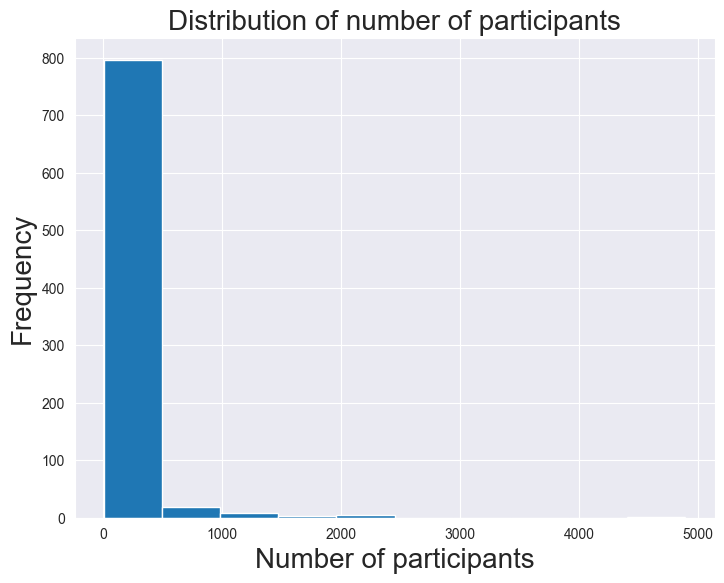

In [13]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(db['participants'])
axes.set_xlabel('Number of participants', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.figsize"] = (5,5)
axes.set_title('Distribution of number of participants')
plt.show();

#shorter version:
#db['participants'].plot(kind = 'hist', grid = True, title = 'Distribution of participants')

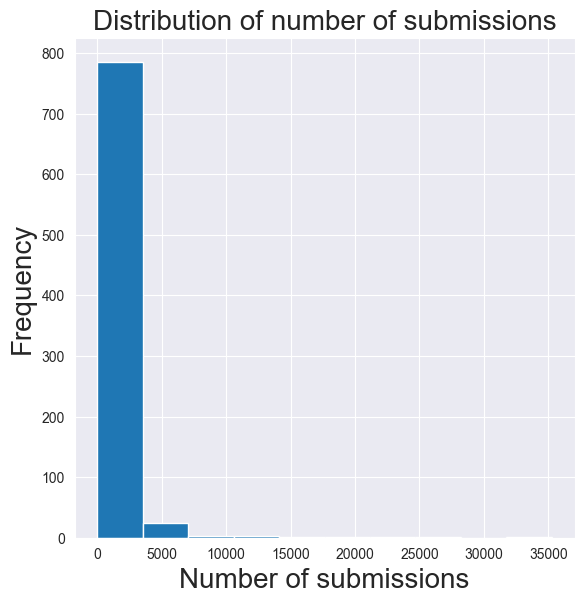

In [14]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(db['submissions'])
axes.set_xlabel('Number of submissions', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
axes.set_title('Distribution of number of submissions')
plt.show()

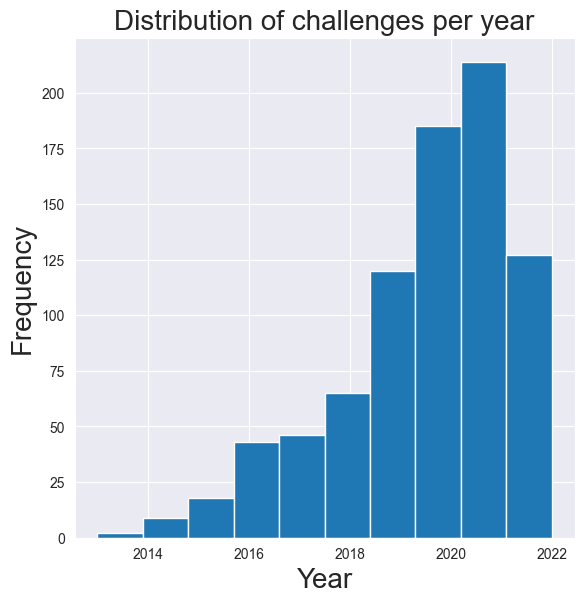

In [15]:
#2022 is not complet
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(db['year'])
axes.set_xlabel('Year', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
axes.set_title('Distribution of challenges per year')
plt.show();

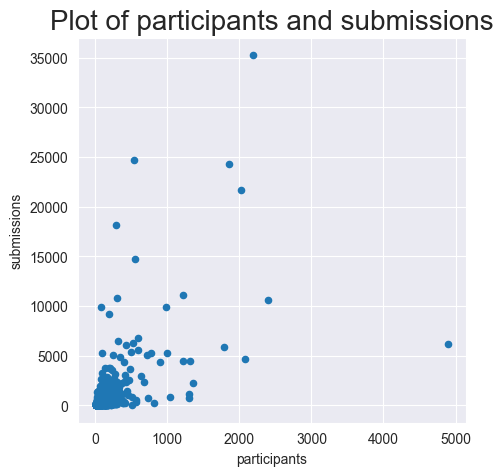

In [16]:
db.plot(x = 'participants', y = 'submissions', kind = 'scatter', grid = True, title = 'Plot of participants and submissions')
plt.savefig("images/participants_submissions.png")

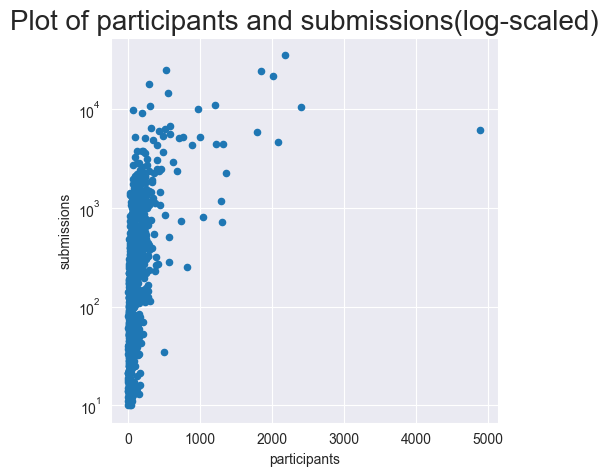

In [17]:
#db.plot(x = 'participants', y = 'log_submissions', kind = 'scatter', grid = True, title = 'Plot of participants and submissions')
db.plot(x = 'participants', y = 'submissions', logy=True, kind = 'scatter', grid = True, \
        title = 'Plot of participants and submissions(log-scaled)')
plt.savefig("images/participants_log_submissions.png")

<AxesSubplot: title={'center': 'Plot of participants and submissions(log-scaled both)'}, xlabel='participants', ylabel='submissions'>

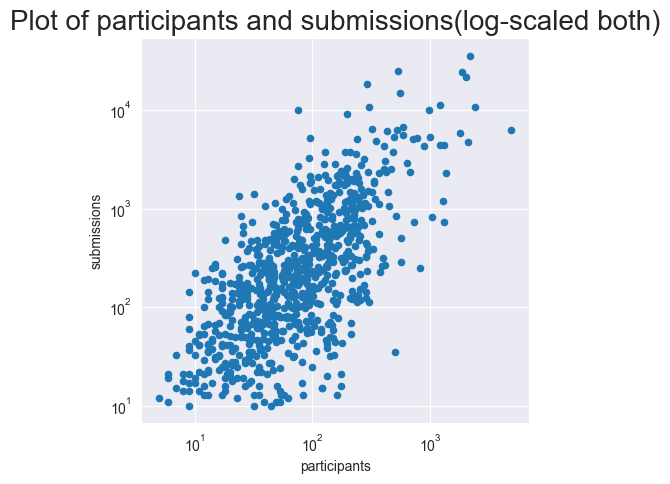

In [18]:
db.plot(x = 'participants', y = 'submissions', logx=True, logy=True, \
        kind = 'scatter', grid = True, title = 'Plot of participants and submissions(log-scaled both)')
#plt.savefig("images/log_participants_log_submissions.png")

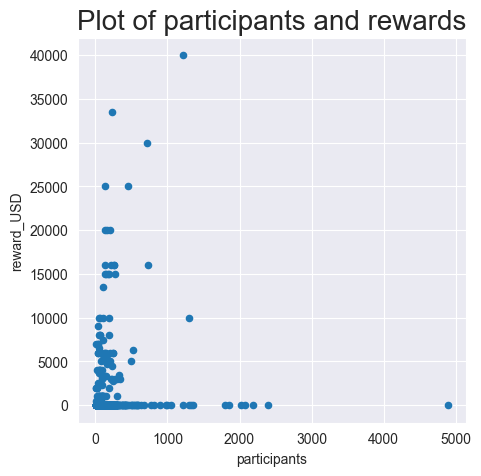

In [19]:
db.plot(x = 'participants', y = 'reward_USD', kind = 'scatter', \
        grid = True, title = 'Plot of participants and rewards')
plt.savefig("images/participants_reward.png")

### Proportion of competitions with prize money

In [20]:
# number of rows
n = len(db)
# number of null reward
db_reward = db[db['reward_USD'] > 0]
with_reward = len(db_reward)

In [21]:
with_reward

102

In [22]:
n

829

In [23]:
with_reward / n

0.12303980699638119

### Average prize

In [24]:
db['reward_USD'].mean()

866.7768395657419

In [18]:
db_reward['reward_USD'].mean()

7051.568627450981

### Max prize

In [19]:
db['reward_USD'].max()

40000

### Influence of reward on participation

In [20]:
rk.corr(db_reward['reward_USD'], db_reward['participants'])

0.2928033444573983

/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_40130/878372822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_reward['participant_bins'] = pd.cut(db_reward['participants'], bins)


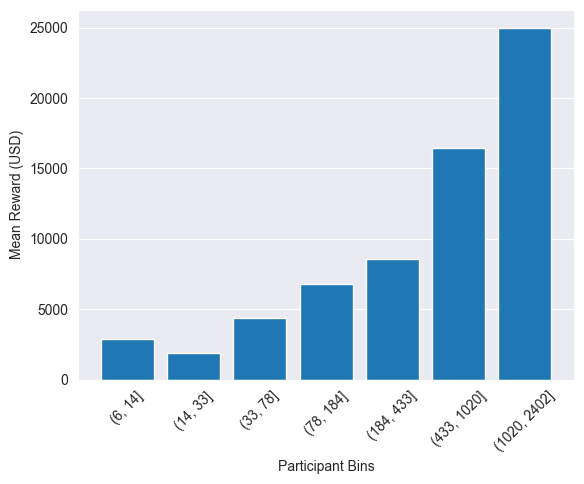

In [21]:
bins = np.logspace(np.log10(6), np.log10(2402), num=8).astype(int)

# Create a new column 'participant_bins' to hold the binned data
db_reward['participant_bins'] = pd.cut(db_reward['participants'], bins)

# Group by 'participant_bins' and calculate mean utility for each group
mean_utility = db_reward.groupby('participant_bins')['reward_USD'].mean().reset_index()

# Create bar plot
plt.bar(mean_utility['participant_bins'].astype(str), mean_utility['reward_USD'])
plt.xlabel('Participant Bins')
plt.ylabel('Mean Reward (USD)')
#plt.title('Mean Reward by Participant Bins')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Show the plot
plt.gca().xaxis.grid(False)
plt.show()

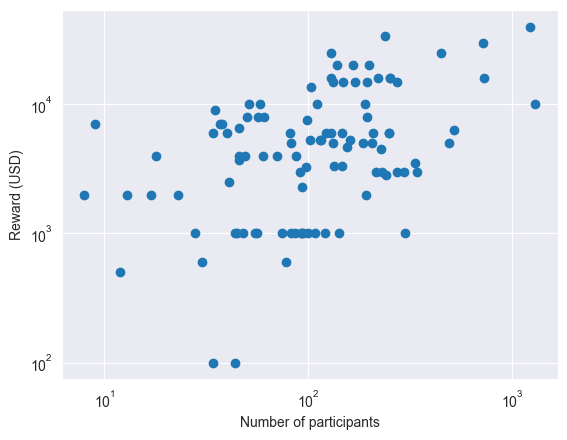

In [22]:
# Scatter plot without log scale
#plt.scatter(db_reward['participants'], db_reward['reward_USD'])
#plt.xlabel('Number of participants')
#plt.ylabel('Reward (USD)')
#plt.title('Linear Scale')
#plt.show()

# Scatter plot with log scale
plt.scatter(db_reward['participants'], db_reward['reward_USD'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of participants')
plt.ylabel('Reward (USD)')
#plt.title('Log Scale')
plt.show()

In [23]:
db['results submission'].value_counts(normalize=True)

True     0.993917
False    0.006083
Name: results submission, dtype: float64

In [24]:
db['code submission'].value_counts(normalize=True)

False    0.836983
True     0.163017
Name: code submission, dtype: float64

In [25]:
db.groupby('year')['code submission'].apply(lambda x: x.value_counts(normalize=True))

year       
2013  False    1.000000
2014  True     0.555556
      False    0.444444
2015  False    0.722222
      True     0.277778
2016  False    1.000000
2017  False    0.934783
      True     0.065217
2018  False    0.892308
      True     0.107692
2019  False    0.895652
      True     0.104348
2020  False    0.842391
      True     0.157609
2021  False    0.784038
      True     0.215962
2022  False    0.787402
      True     0.212598
Name: code submission, dtype: float64

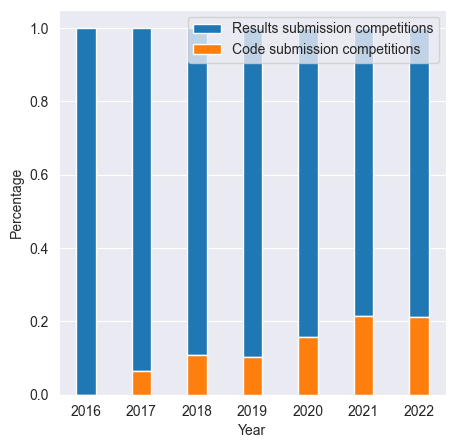

In [25]:
import matplotlib.pyplot as plt
import numpy as np

year = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
code_ratio = [0.0, 0.065, 0.108, 0.104, 0.158, 0.216, 0.212]
result_ratio = [1 - x for x in code_ratio]

ind = np.arange(len(year))    # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

# Create stacked bars
bar2 = ax.bar(ind, result_ratio, width, bottom=code_ratio, label='Results submission competitions')
bar1 = ax.bar(ind, code_ratio, width, label='Code submission competitions')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_xticks(ind)
ax.set_xticklabels(year)
ax.legend()

plt.gca().xaxis.grid(False)
plt.show()

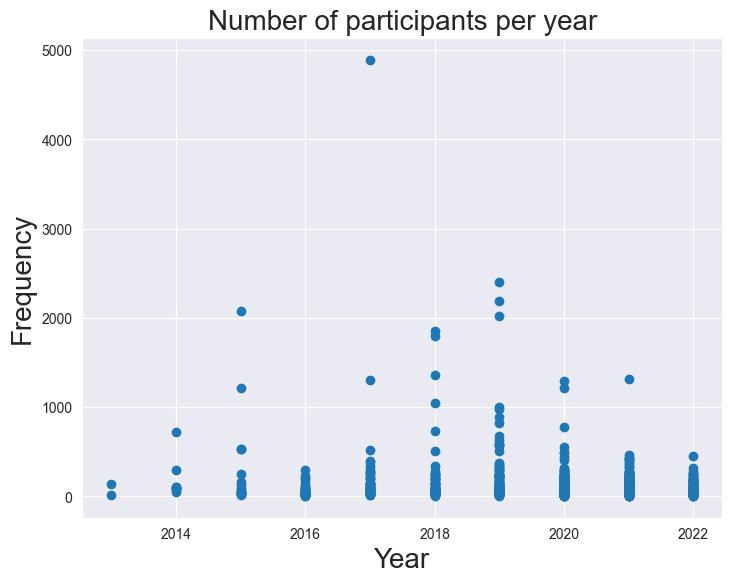

In [27]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_xlabel('Year', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
plt.rcParams['axes.titlesize'] = 20
axes.set_title('Number of participants per year')
axes.scatter(x = db['year'], y = db['participants'])
plt.show()

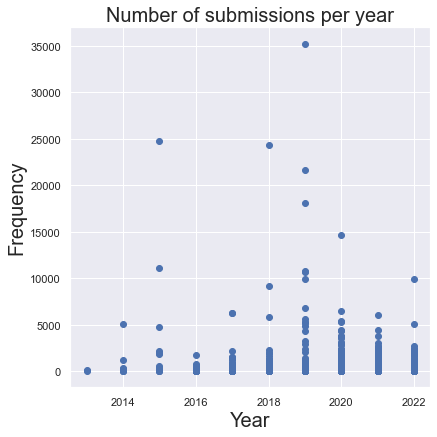

In [169]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_xlabel('Year', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
plt.rcParams['axes.titlesize'] = 20
axes.set_title('Number of submissions per year')
axes.scatter(x = db['year'], y = db['submissions'])

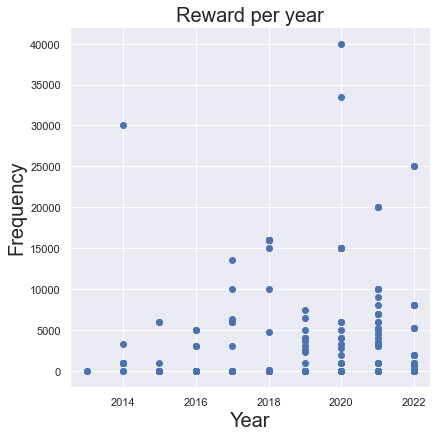

In [170]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_xlabel('Year', fontsize=20)
axes.set_ylabel('Frequency', fontsize=20)
plt.rcParams['axes.titlesize'] = 20
axes.set_title('Reward per year')
axes.scatter(x = db['year'], y = db['reward_USD'])
plt.show()

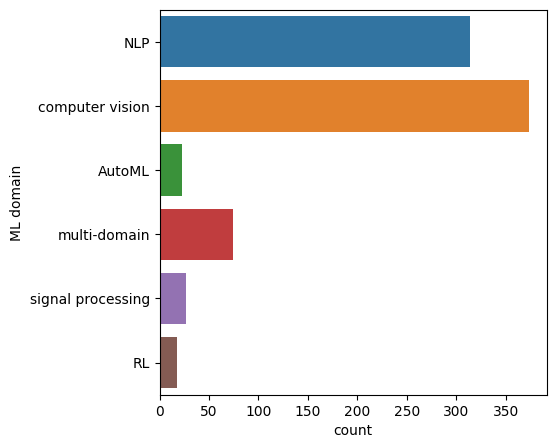

In [62]:
sns.countplot(y = 'ML domain',  data = db); 

<AxesSubplot: title={'center': 'Machine learning domains distribution'}>

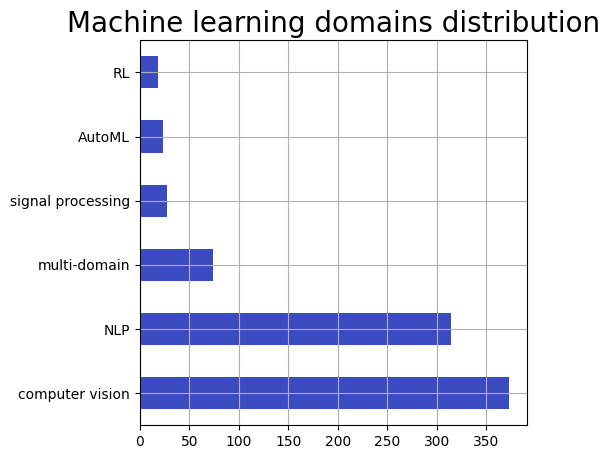

In [63]:
# second version
db['ML domain'].value_counts().plot(kind = 'barh', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Machine learning domains distribution')

<AxesSubplot: xlabel='count', ylabel='ML domain'>

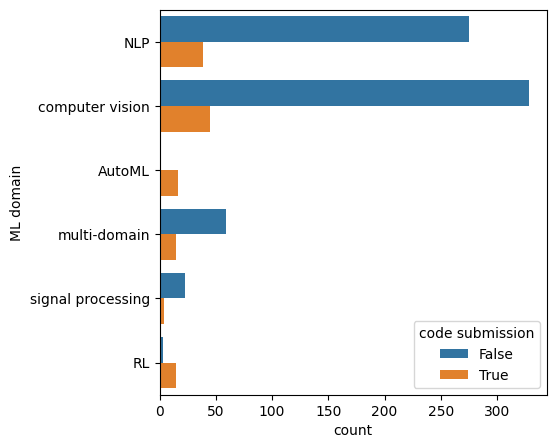

In [64]:
# TODO: better visualization
sns.countplot(y = 'ML domain',  data = db, hue = "code submission") 

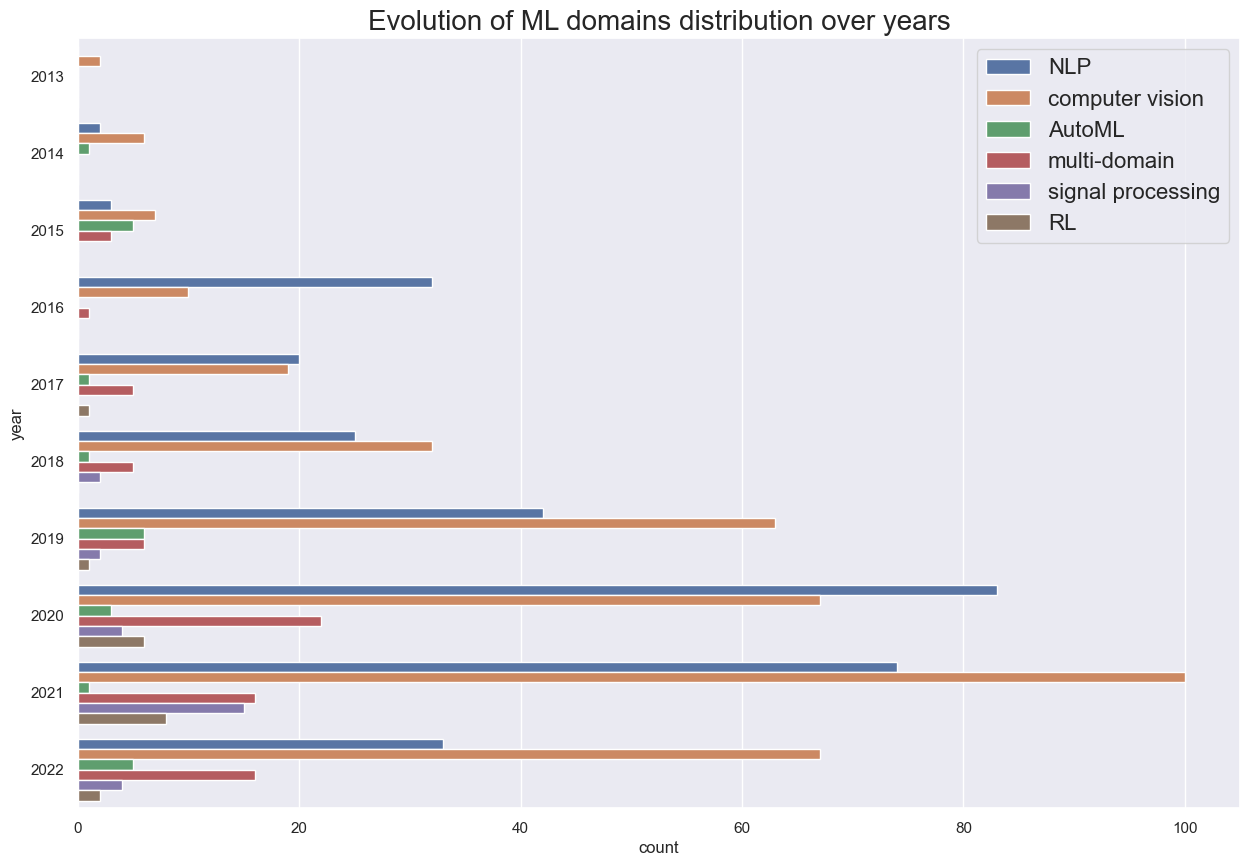

In [65]:
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.countplot(y="year", hue="ML domain", data=db)
plt.legend(loc='upper right',fontsize = 16)
plt.title("Evolution of ML domains distribution over years", fontsize=20)
fig = ax.get_figure()
fig.savefig('images/MLdomains_years.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


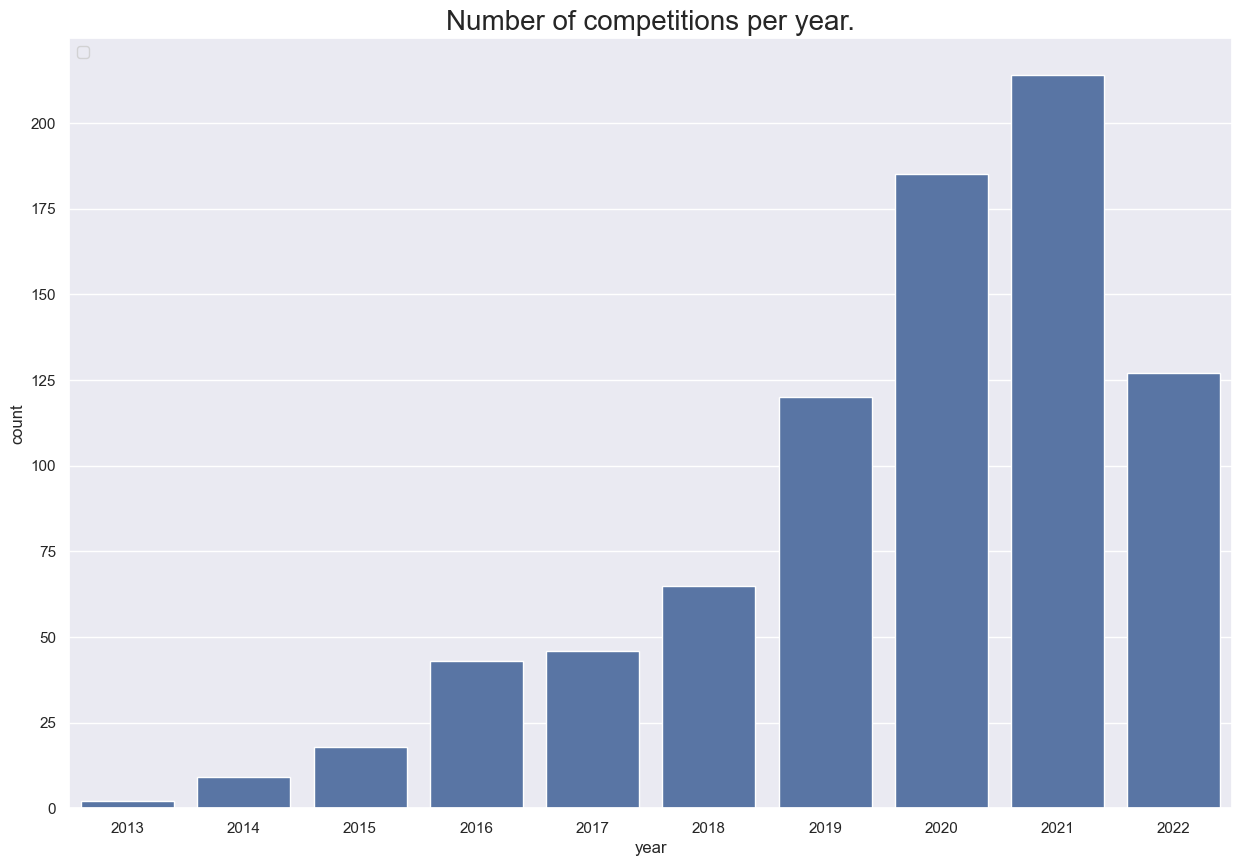

In [66]:
sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.countplot(x="year", data=db, color='#5975a4', saturation=1)
plt.legend(loc='upper left')
plt.title("Number of competitions per year.", fontsize=20)
fig = ax.get_figure()
#fig.savefig('images/Nbr_compet_year.png')

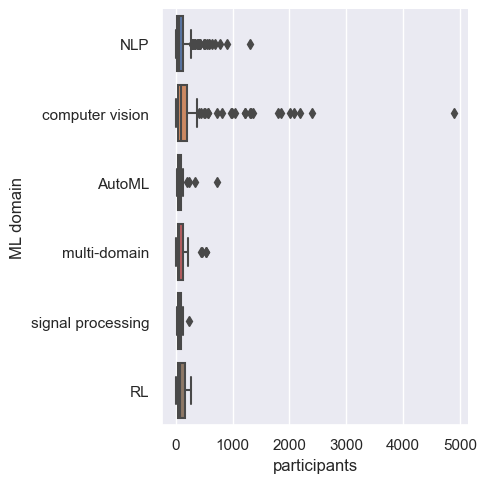

In [67]:
sns.catplot(x="participants", y="ML domain", kind="box", data=db, orient="h")

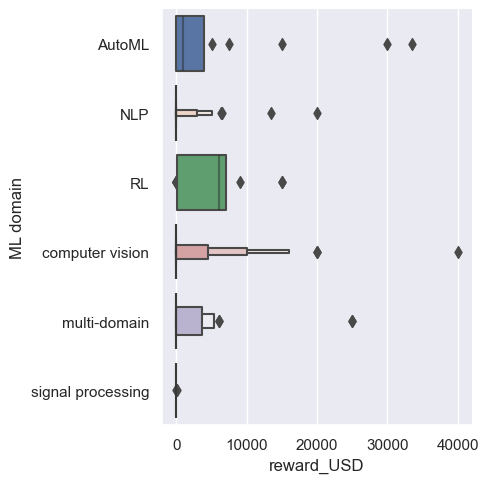

In [68]:
sns.catplot(x="reward_USD", y="ML domain", kind="boxen", # x="log_reward"
            data=db.sort_values("ML domain"), orient="h")

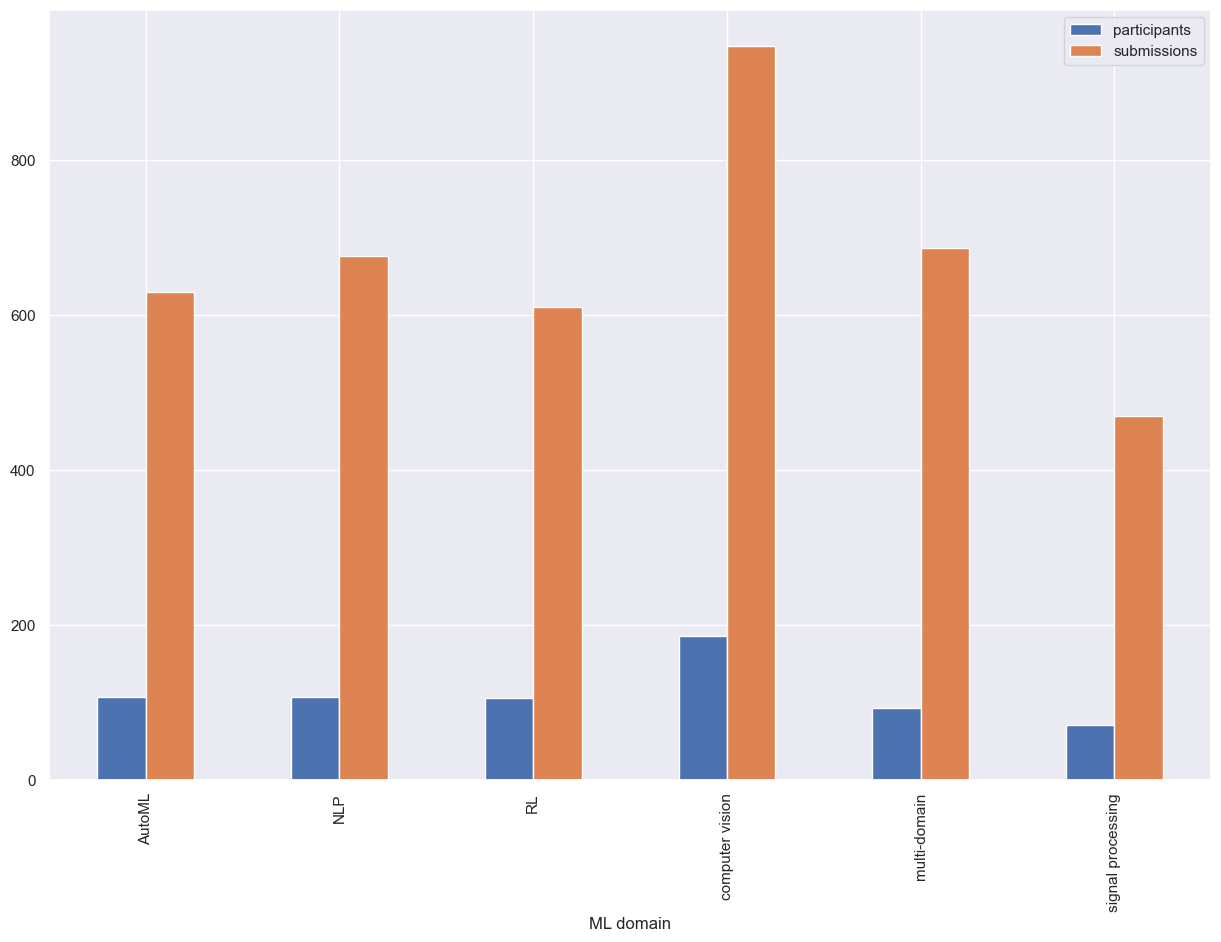

In [69]:
db.pivot_table(values = ['participants', 'submissions'], index = 'ML domain', aggfunc = 'mean').plot(kind = 'bar')
plt.rcParams["figure.figsize"] = (20,3)

## It's pie chart time!

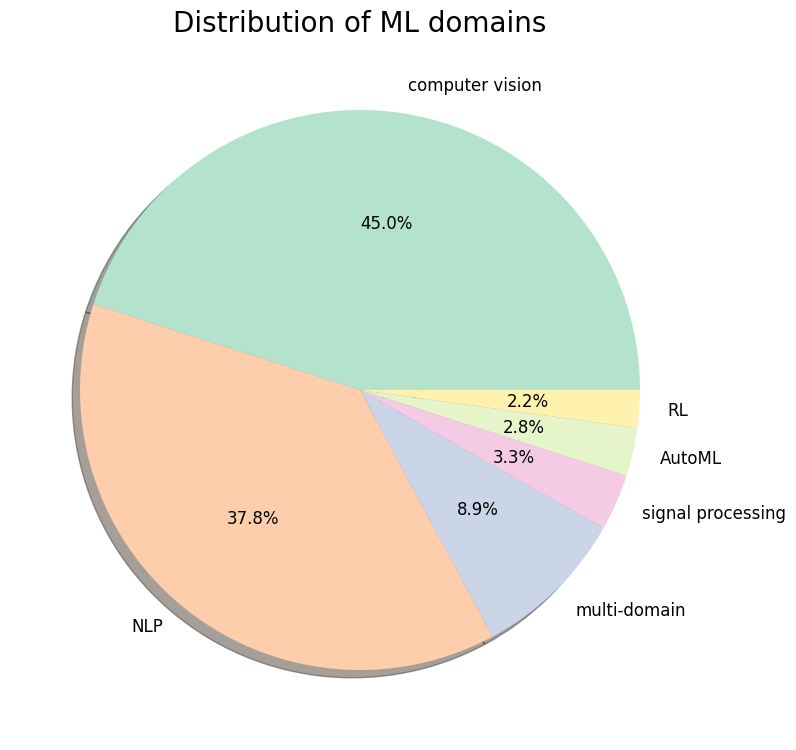

In [3]:
cmap = plt.get_cmap('Pastel2')

# ML DOMAINS
df_domains = db.groupby('ML domain', axis=0).count()
d_labels = df_domains['title'].sort_values(ascending=False).index
d_counts = df_domains['title'].sort_values(ascending=False)

plt.figure(1, figsize=(40,20)) 
the_grid = GridSpec(2, 2)

colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.rcParams['axes.titlesize'] = 20
plt.subplot(the_grid[0, 1], aspect=1, title='Distribution of ML domains')
type_show_ids = plt.pie(d_counts, labels=d_labels, autopct='%1.1f%%', textprops={'fontsize': 12}, \
                        shadow=True, colors=colors)
plt.show()

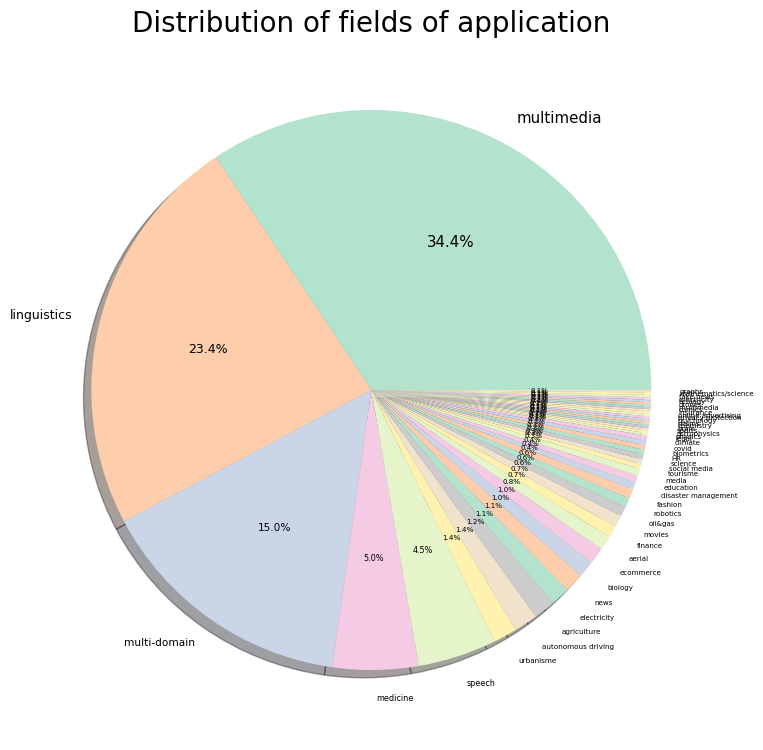

In [38]:
def size_to_fontsize(size, min_size=5, max_size=22):
    return ((max_size - min_size) * (size / 100.0)) + min_size

# FIELDS OF APPLICATION
df_fields = db.groupby('field of application', axis=0).count()
f_labels = df_fields['title'].sort_values(ascending=False).index
f_counts = df_fields['title'].sort_values(ascending=False)

plt.figure(1, figsize=(40,20)) 
the_grid = GridSpec(2, 2)

colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.rcParams['axes.titlesize'] = 20
plt.subplot(the_grid[0, 1], aspect=1, title='Distribution of fields of application')

patches, texts, autotexts = plt.pie(f_counts, labels=f_labels, autopct='%1.1f%%', \
                        shadow=True, colors=colors)

for text, autotext in zip(texts, autotexts):
    size = float(autotext.get_text().replace('%', ''))  # get the percentage as a float
    fontsize = size_to_fontsize(size)  # calculate the corresponding font size
    text.set_fontsize(fontsize)
    autotext.set_fontsize(fontsize)

plt.show()


---

# Utility

In [26]:
# Utility
# Keep only one float for each utility
# Remove other rows

def handle_nan_and_convert(value):
    try:
        # convert to float if possible, otherwise check if it's 'nan'
        return float(value) if value != 'nan' else 0.0
    except ValueError:
        # value is not a number nor 'nan', return a default value or handle as per your requirement
        return 0.0 #np.nan 

def convert_list_values_to_float(list_string):
    list_elements = list_string.strip('][').split(', ')
    return [handle_nan_and_convert(element) for element in list_elements]

# Apply the function to the 'utility' column
db['utility'] = db['utility'].apply(convert_list_values_to_float)

# Keep only rows where the utility list is not empty
db = db[db['utility'].apply(len) > 0]

# Keep only rows where the max utility is above or equal to 1
db = db[db['utility'].apply(lambda utilities: max(utilities) >= 1)]

# Replace the utility list by the max utility
db['utility'] = db['utility'].apply(max)


In [27]:
db.head()

,title,description,participants,submissions,year,phases,reward,reward_USD,duration_day,challenge,website,papers,winner's code,dataset,field of application,ML domain,real task,ML task,dataset size,dataset details,score,metrics,multi-score,multi-task,results submission,code submission,remark,utility,submission_per_participant,log_reward,log_submissions,log_participants
0,The Third Evaluation Workshop on Chinese Machi...,It is the sentence cloze-style machine reading...,46,248.0,2019,3.0,6500 USD,6500,87.0,https://competitions.codalab.org/competitions/...,https://hfl-rc.com/cmrc2019/; https://ymcui.co...,https://arxiv.org/pdf/2004.03116.pdf,None,https://github.com/ymcui/cmrc2019,multi-domain,NLP,sentence cloze-style machine reading comprehen...,machine reading comprehension,10000,NaN,QAC,"Question Accuracy (QAC),Passage Accuracy (PAC)...",True,False,True,False,https://github.com/ymcui/cmrc2019/tree/master/...,1.403988,5.391304,8.779711,5.513429,3.828641
1,Pose-guided Human Rendering Benchmark Challenge,HUMBI is an ideal dataset to evaluate the abil...,12,65.0,2013,1.0,0,0,NaN,https://competitions.codalab.org/competitions/...,https://www.humbi-data.net/,https://arxiv.org/pdf/2110.00119.pdf; https://...,None,https://competitions.codalab.org/competitions/...,NaN,computer vision,posture generation,image generation,374352,"366300 train images, 7674 validation images, 3...",Mrmse,"RMSE, MRMSE, SSIM, MSSIM, ranking is based on ...",False,False,True,False,https://github.com/Gorokke/humanrender_class,1.192141,5.416667,0.000000,4.174387,2.484907
3,ChaLearn LAP 2014 - Track 1: Human Pose Recovery,"More than 8,000 frames of continuous RGB seque...",100,25.0,2014,2.0,1000 USD,1000,108.0,https://competitions.codalab.org/competitions/971,https://gesture.chalearn.org/2014-looking-at-p...,https://www.researchgate.net/publication/28984...,None,http://sunai.uoc.edu/chalearnLAP/,NaN,computer vision,human pose recovery from RGB data,image recognition,8234,"4,000 dev labelled frames, 2,000 validation la...",Overlap,Jaccard Index (overlapping),False,False,True,True,NaN,1.829352,0.250000,6.908755,3.218876,4.605170
4,ChaLearn LAP 2014 - Track 2: Action Recognition,Recognizing actions/interactions using 235 per...,108,36.0,2014,2.0,1000 USD,1000,108.0,https://competitions.codalab.org/competitions/981,NaN,NaN,None,http://sunai.uoc.edu/chalearnLAP/,NaN,computer vision,action and interaction recognition from RGB da...,image recognition,NaN,235 action samples performed by 17 actors,Overlap,Jaccard Index (overlapping),False,False,True,True,NaN,2.079579,0.333333,6.908755,3.583519,4.682131
5,ChaLearn LAP 2014 - Track 3: Gesture Recognition,Recognizing gestures drawn from a vocabulary o...,299,373.0,2014,2.0,1000 USD,1000,108.0,https://competitions.codalab.org/competitions/991,NaN,NaN,None,http://sunai.uoc.edu/chalearnLAP/,NaN,computer vision,multi-modal gesture recognition from RGB-Depth...,image recognition,NaN,14K manually labeled (beginning and ending fra...,Overlap,Jaccard Index (overlapping),False,False,True,True,NaN,1.360556,1.247492,6.908755,5.921578,5.700444


In [28]:
db.describe()

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,participants,submissions,year,phases,reward_USD,duration_day,utility,submission_per_participant,log_reward,log_submissions,log_participants
count,479.000000,479.000000,479.000000,479.000000,479.000000,468.000000,479.000000,479.000000,479.00000,479.000000,479.000000
mean,144.231733,844.751566,2019.695198,2.392484,835.363257,904.147436,1.730857,5.714620,-inf,5.466142,4.294570
std,264.994353,2628.281939,1.875575,1.920062,3391.513989,4222.602020,2.357710,8.804424,NaN,1.495492,1.081088
min,6.000000,10.000000,2013.000000,1.000000,-1.000000,0.000000,1.000000,0.193548,-inf,2.302585,1.791759
25%,35.000000,83.000000,2019.000000,2.000000,-1.000000,48.000000,1.106631,1.548049,NaN,4.418841,3.555348
50%,71.000000,231.000000,2020.000000,2.000000,-1.000000,73.000000,1.231837,3.453333,NaN,5.442418,4.262680
75%,148.000000,594.000000,2021.000000,2.000000,-1.000000,120.250000,1.486299,7.174675,NaN,6.386879,4.997189
max,2401.000000,35260.000000,2022.000000,19.000000,40000.000000,29384.000000,27.000000,129.763158,10.59666,10.470504,7.783641


### Plot utility vs participants (empirical)

In [31]:
db['submissions'].max()

35260.0

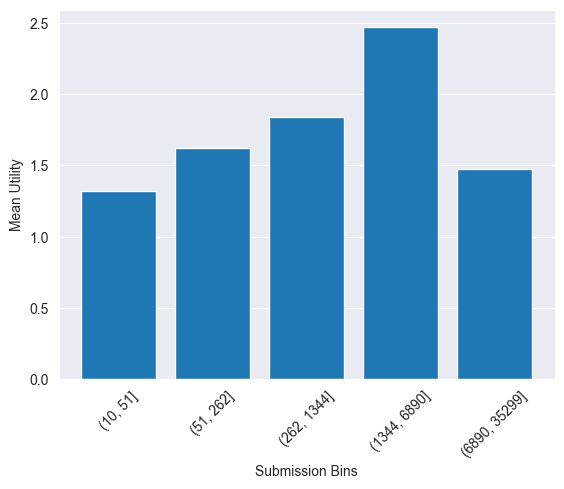

In [32]:
bins = np.logspace(np.log10(10), np.log10(35300), num=6).astype(int)

# Create a new column 'participant_bins' to hold the binned data
db['submission_bins'] = pd.cut(db['submissions'], bins)

# Group by 'participant_bins' and calculate mean utility for each group
mean_utility = db.groupby('submission_bins')['utility'].mean().reset_index()

# Create bar plot
plt.bar(mean_utility['submission_bins'].astype(str), mean_utility['utility'])
plt.xlabel('Submission Bins')
plt.ylabel('Mean Utility')
#plt.title('Mean Utility by Submission Bins')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Show the plot
plt.gca().xaxis.grid(False)
plt.show()

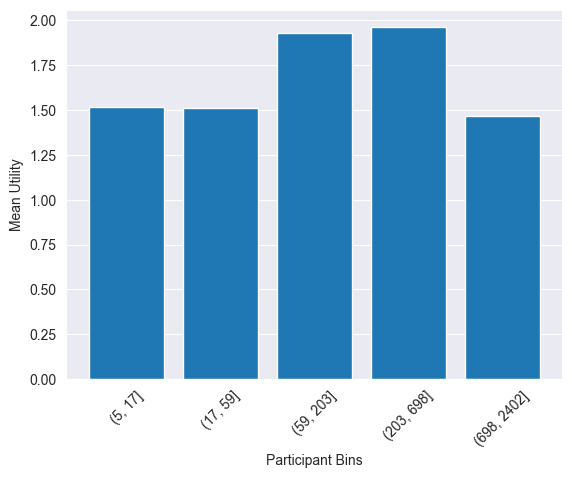

In [34]:
bins = np.logspace(np.log10(5), np.log10(2402), num=6).astype(int)

# Create a new column 'participant_bins' to hold the binned data
db['participant_bins'] = pd.cut(db['participants'], bins)

# Group by 'participant_bins' and calculate mean utility for each group
mean_utility = db.groupby('participant_bins')['utility'].mean().reset_index()

# Create bar plot
plt.bar(mean_utility['participant_bins'].astype(str), mean_utility['utility'])
plt.xlabel('Participant Bins')
plt.ylabel('Mean Utility')
#plt.title('Mean Utility by Participant Bins')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Show the plot
plt.gca().xaxis.grid(False)
plt.show()

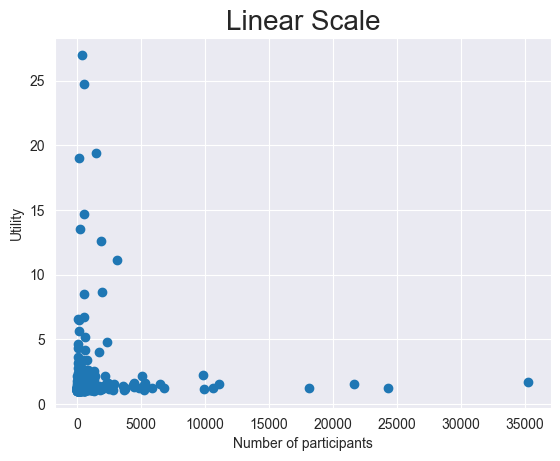

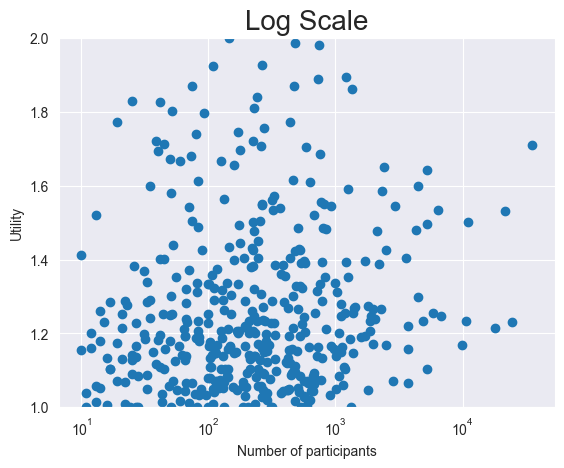

In [35]:
# Scatter plot without log scale
plt.scatter(db['submissions'], db['utility'])
plt.xlabel('Number of participants')
plt.ylabel('Utility')
plt.title('Linear Scale')
plt.show()

# Scatter plot with log scale
plt.scatter(db['submissions'], db['utility'])
plt.xscale('log')
#plt.yscale('log')
plt.ylim(1, 2)
plt.xlabel('Number of participants')
plt.ylabel('Utility')
plt.title('Log Scale')
plt.show()

(0.0, 3.0)

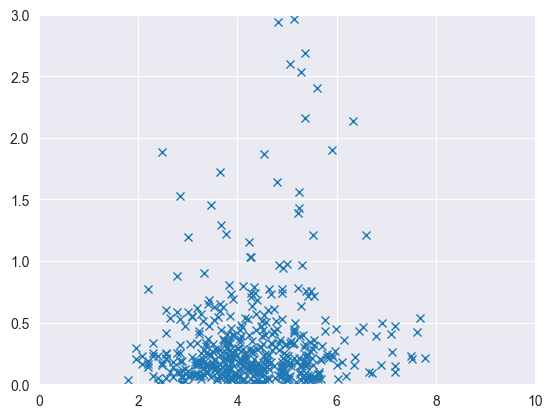

In [36]:
#participants, utilities = list(db['log_participants']), list(db['utility'])
plt.plot(np.log(db['participants']), np.log(db['utility']), 'x')
plt.xlim(0, 10)
plt.ylim(0, 3)

# Correlation matrix

In [244]:
db.corr()

/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_26971/2287404026.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  db.corr()


,participants,submissions,year,phases,reward_USD,duration_day,utility,submission_per_participant,log_reward,log_submissions,log_participants
participants,1.000000,0.735240,-0.089758,0.027645,0.172298,-0.064388,0.019198,0.008814,-0.173888,0.541535,0.726229
submissions,0.735240,1.000000,-0.033648,0.053161,0.038803,-0.042307,0.007858,0.373028,-0.334501,0.569305,0.463314
year,-0.089758,-0.033648,1.000000,0.030965,0.002478,-0.016340,0.006540,0.116578,0.375950,0.060543,-0.064010
phases,0.027645,0.053161,0.030965,1.000000,-0.003575,-0.074025,-0.027975,0.212089,0.166521,0.215504,0.049937
reward_USD,0.172298,0.038803,0.002478,-0.003575,1.000000,-0.038601,0.088230,-0.029784,0.586088,0.146512,0.214313
duration_day,-0.064388,-0.042307,-0.016340,-0.074025,-0.038601,1.000000,-0.036649,-0.041341,-0.019181,-0.100353,-0.126718
utility,0.019198,0.007858,0.006540,-0.027975,0.088230,-0.036649,1.000000,0.004795,0.142918,0.095604,0.096188
submission_per_participant,0.008814,0.373028,0.116578,0.212089,-0.029784,-0.041341,0.004795,1.000000,-0.114962,0.487452,-0.013682
log_reward,-0.173888,-0.334501,0.375950,0.166521,0.586088,-0.019181,0.142918,-0.114962,1.000000,0.031012,0.163815
log_submissions,0.541535,0.569305,0.060543,0.215504,0.146512,-0.100353,0.095604,0.487452,0.031012,1.000000,0.688047


/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_26971/1370929774.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(db[['participants', 'submissions', 'year','reward_USD', 'duration_day','code submission',\


<AxesSubplot: >

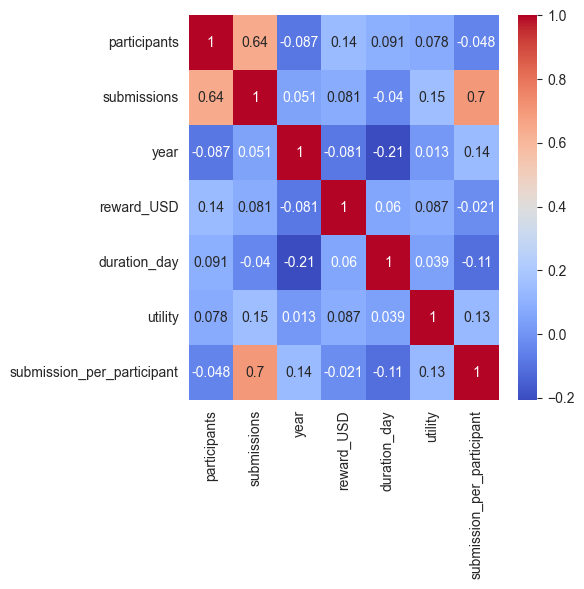

In [245]:
sns.heatmap(db[['participants', 'submissions', 'year','reward_USD', 'duration_day','code submission',\
                'utility', 'submission_per_participant']].corr(method='spearman'), annot = True, cmap = 'coolwarm')

/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_26971/4014728876.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(db.corr(method='spearman'), annot = True, cmap = 'coolwarm')


<AxesSubplot: >

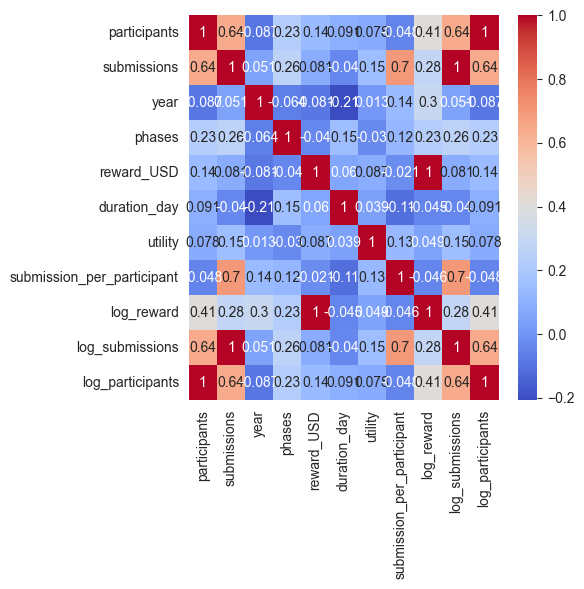

In [246]:
sns.heatmap(db.corr(method='spearman'), annot = True, cmap = 'coolwarm')

# Pairplots

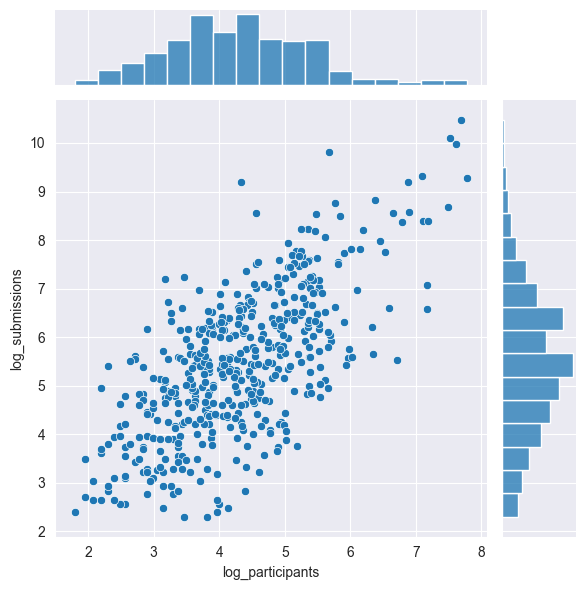

In [247]:
sns.jointplot(x = 'log_participants', y = 'log_submissions', data = db)

In [248]:
#sns.pairplot(db[['participants', 'submissions', 'year', 'reward_USD', 'duration_day', 'results submission','code submission']])#, hue = 'smoker')

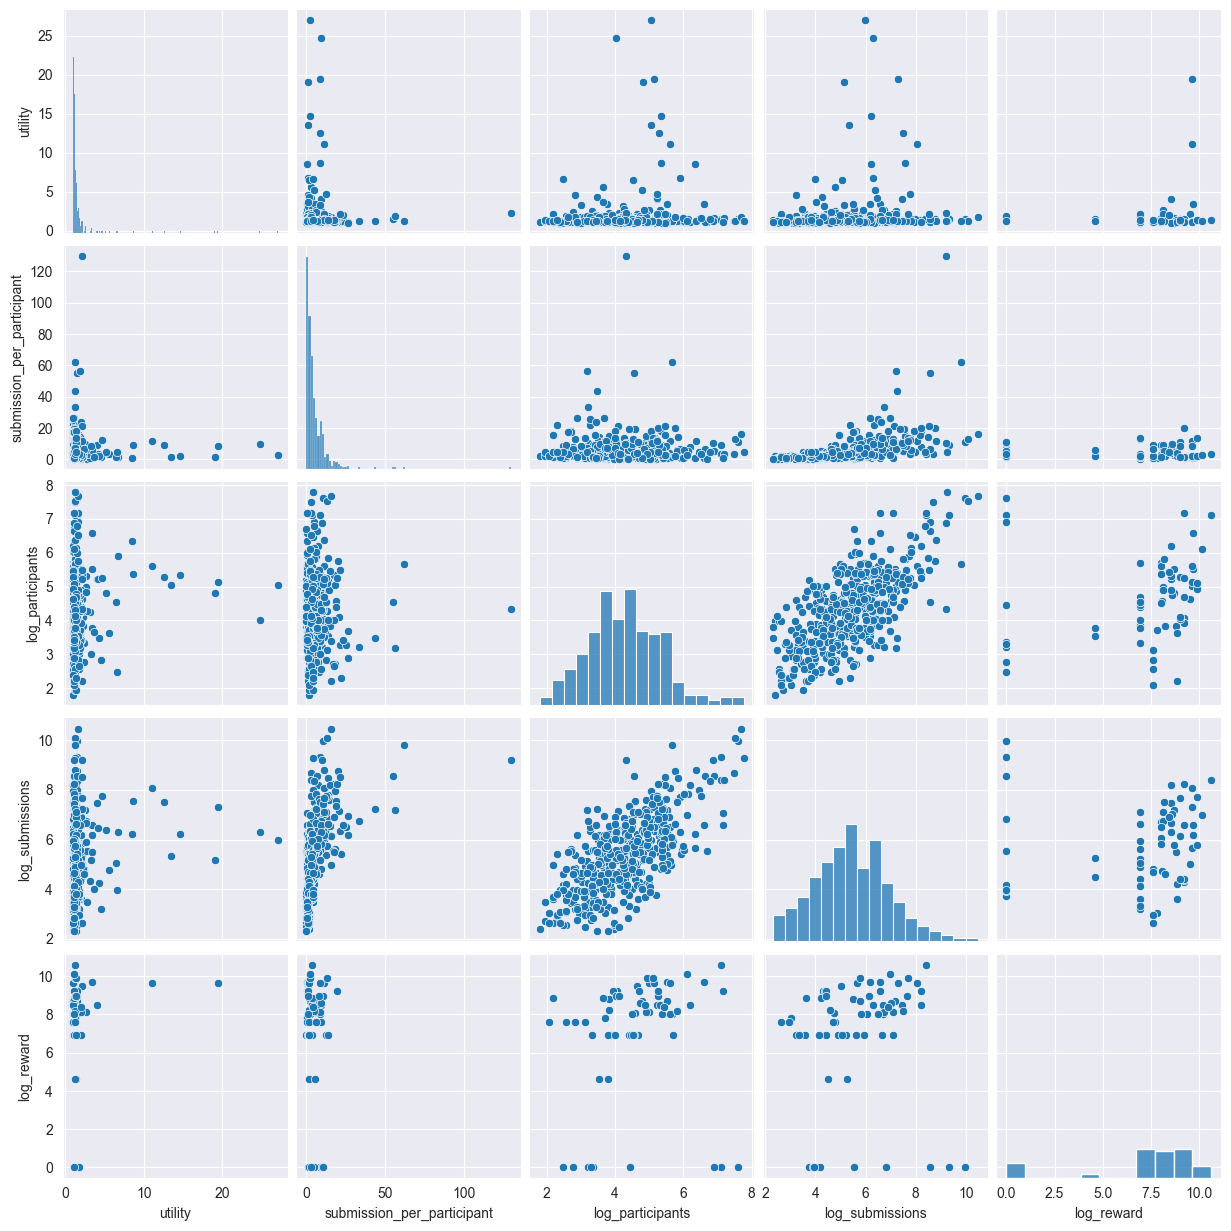

In [249]:
sns.pairplot(db[['utility', \
                 #'u_median', \
                 'submission_per_participant', \
                 'log_participants', \
                 'log_submissions', \
                 #'year', \
                 'log_reward']])#, hue = 'code submission')

## Feature importances with a forest of trees

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [29]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import time

In [30]:
db_features=db.dropna(subset=['utility'])

In [31]:
y=db_features['utility']
X=db_features[['participants','submissions','year','phases','reward_USD','duration_day','multi-score',\
      'multi-task','results submission','code submission','submission_per_participant']]

In [32]:
# Interpolation
X.fillna(X.mean(),inplace=True)

/var/folders/48/4n4hcp112zbdf81wrzbqmc3c0000gn/T/ipykernel_40394/3466485939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(),inplace=True)


In [33]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = list(X_train.columns)
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [34]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


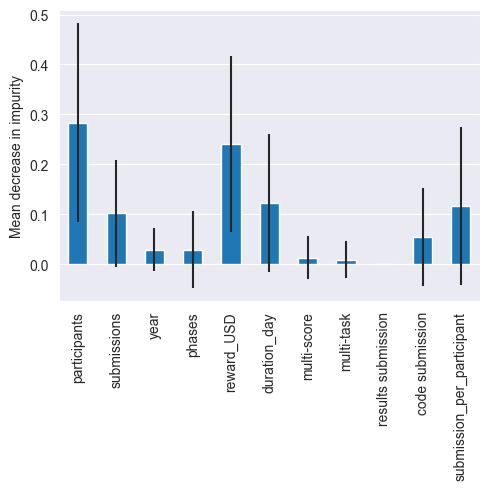

In [35]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.tight_layout()
plt.rcParams["figure.figsize"] = (20,20)
plt.gca().xaxis.grid(False)

## Feature importance based on feature permutation

In [94]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 1.366 seconds


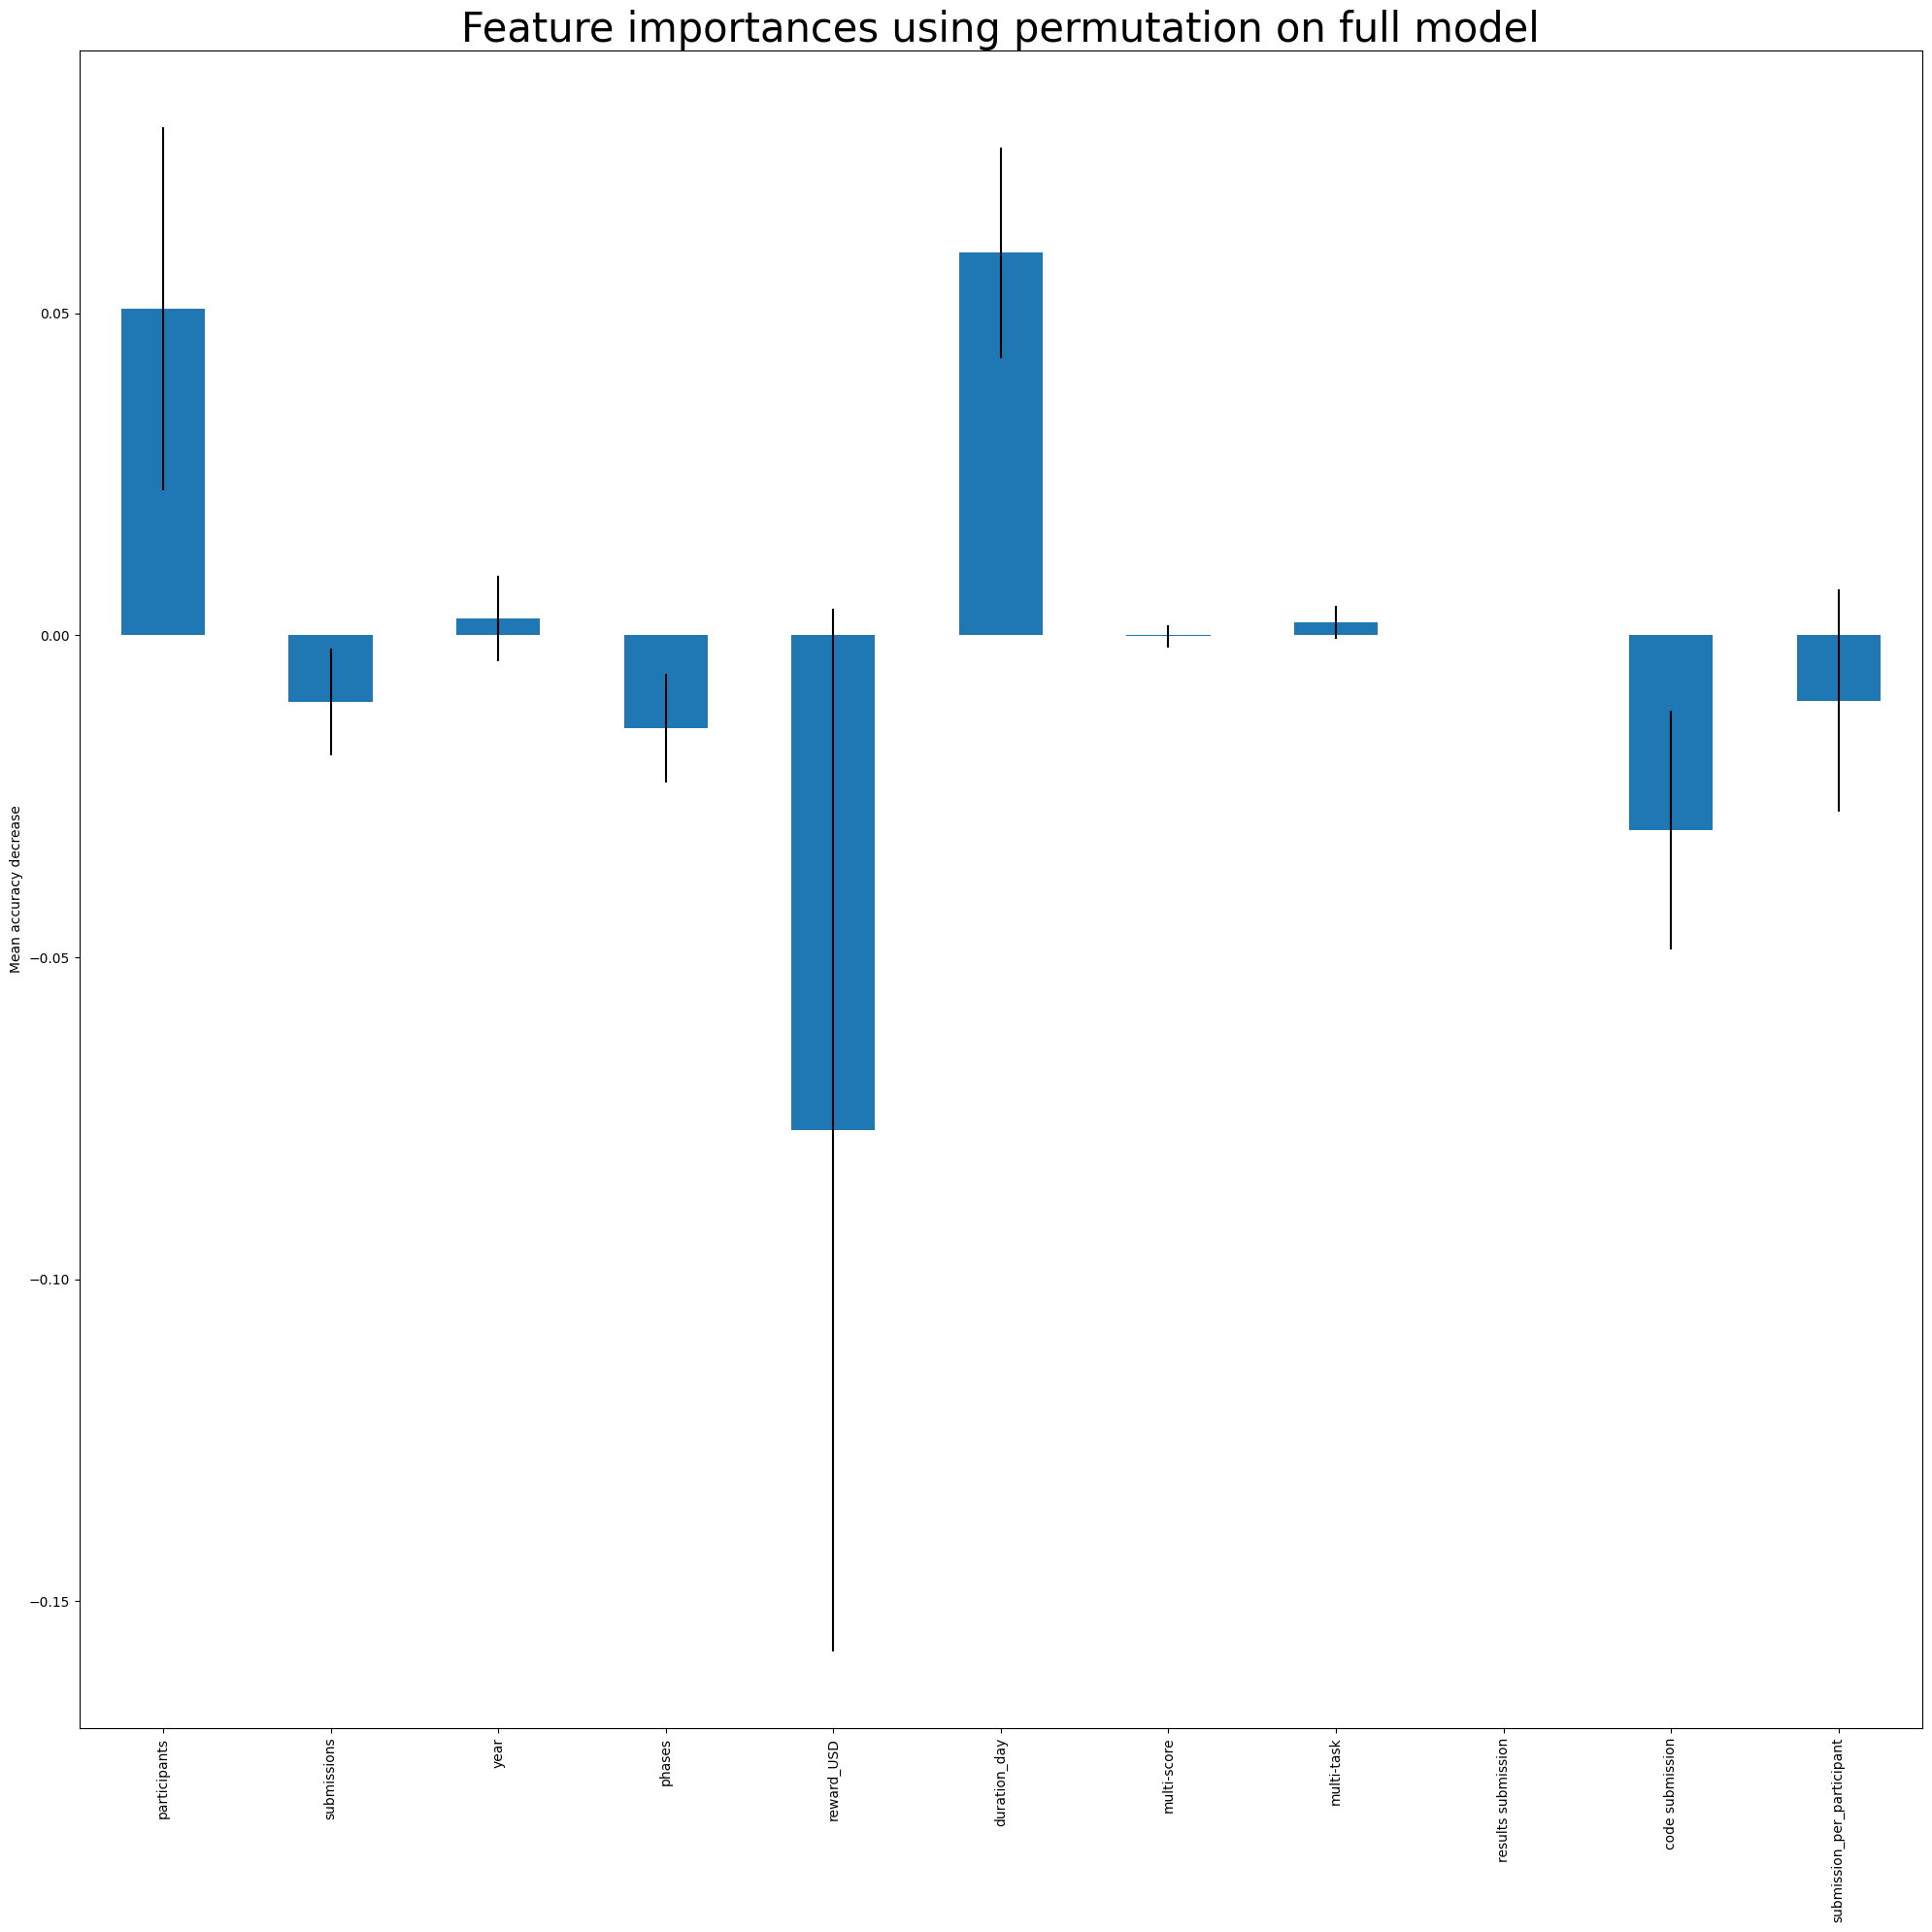

In [95]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model", fontsize=30)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
plt.rcParams["figure.figsize"] = (20,10)